### Generare le istanze

Prima assicurati di avere tutti i pachetti necessari installati. Se non hai installato i pacchetti, esegui il comando seguente: 
```bash
pip3 install -r requirements.txt
```

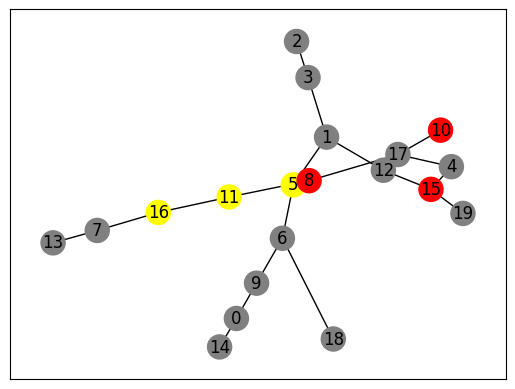

Number of edges:  19
Weight of the edges of the tree:  {(0, 14): 189.62067397834025, (0, 9): 185.22418848519757, (1, 3): 110.90987332063814, (1, 5): 132.5028301584536, (1, 12): 126.08727136392476, (2, 3): 144.55794685869054, (4, 17): 91.54780172128658, (4, 15): 115.15641536623133, (5, 6): 151.71354586852158, (6, 9): 125.78155667664477, (6, 18): 14.317821063276353, (7, 13): 151.90786681406595, (7, 16): 141.89080308462562, (8, 11): 146.74126890551273, (8, 17): 99.20181449953424, (10, 17): 145.60219778561037, (11, 16): 154.00324671902212, (12, 15): 212.20744567521658, (15, 19): 212.9812198293549}
Number of nodes:  20
Number of flows:  3
Flows with their source and destination: [['8', '5'], ['10', '16'], ['15', '11']]


In [2]:
import networkx as nx
import utility_functions as uf

# CREATING A TREE NETWORK WITH 3 FLOWS AND 150 AUTONOMY

N = 20 #number of nodes
K = 3 #number of flows
L = 150 #autonomy of the vehicles

T = uf.generate_random_network_tree(N, K, 200)
flows = uf.get_random_flows(T, K)

uf.draw_tree(T, flows)

nx.write_gml(T, "tree_net/bigtree.gml")

print("Number of edges: ", T.number_of_edges())
print("Weight of the edges of the tree: ", uf.get_weight_of_edges(T))
print("Number of nodes: ", T.number_of_nodes())
print("Number of flows: ", T.graph['K'])
print("Flows with their source and destination:", flows)

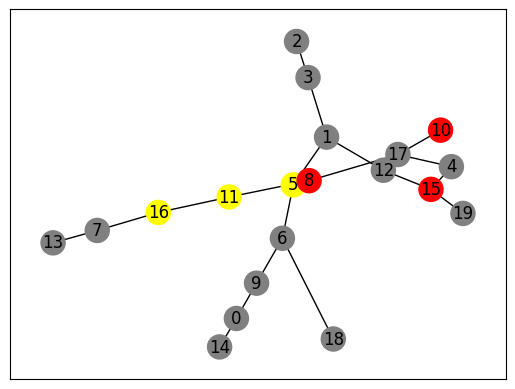

In [3]:
# READING THE TREE NETWORK FROM THE .gml FILE 
path_tree = "tree_net/bigtree.gml"
T = nx.read_gml(path_tree)
uf.draw_tree(T, flows)

### Prima greedy naive

1. Iniziamo con un insieme vuoto di stazioni di ricarica.
2. Per ogni flusso da origine a destinazione, seguiamo il percorso dell'albero, che è unico. Ogni veicolo (flusso) parte con autonomia L.
3. Mentre percorriamo il percorso, diminuiamo l'autonomia del veicolo della lunghezza dell'arco che si percorre.
4. Se l'autonommia non è sufficiente per percorrere il prossimo arco del percorso, quindi percorrendolo scenderebbe a zero o meno, posizioniamo una colonnina di ricarica sul nodo corrente.
5. Ripetiamo i passaggi 3-4 fino a quando tutti i veicoli hanno raggiunto le loro destinazioni.

Questa euristica cerca di minimizzare il numero di stazioni di ricarica posizionando ogni stazione il più lontano possibile lungo ogni percorso, dato che ogni veicolo parte con la carica completa e ogni stazione di ricarica ricarica completamente la batteria del veicolo.

Flows with their source and destination: [['8', '5'], ['10', '16'], ['15', '11']]
Paths (a path for each flow): [['8', '17', '4', '15', '12', '1', '5'], ['10', '17', '8', '11', '16'], ['15', '4', '17', '8', '11']]
Weight of the edges of the tree:  {('0', '14'): 189.62067397834025, ('0', '9'): 185.22418848519757, ('1', '3'): 110.90987332063814, ('1', '5'): 132.5028301584536, ('1', '12'): 126.08727136392476, ('2', '3'): 144.55794685869054, ('4', '17'): 91.54780172128658, ('4', '15'): 115.15641536623133, ('5', '6'): 151.71354586852158, ('6', '9'): 125.78155667664477, ('6', '18'): 14.317821063276353, ('7', '13'): 151.90786681406595, ('7', '16'): 141.89080308462562, ('8', '11'): 146.74126890551273, ('8', '17'): 99.20181449953424, ('10', '17'): 145.60219778561037, ('11', '16'): 154.00324671902212, ('12', '15'): 212.20744567521658, ('15', '19'): 212.9812198293549}
Charging stations on nodes: {'11', '1', '15', '17', '4', '8'}
COST: (number of charging stations): 6


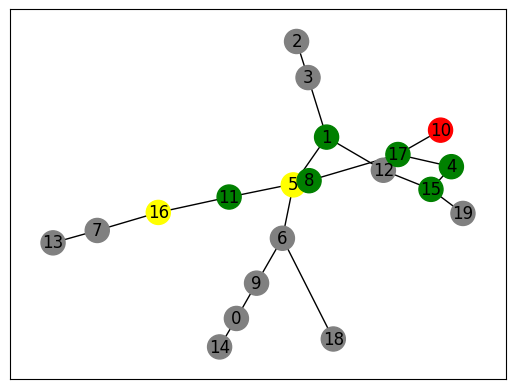

In [4]:

def greedy_electric_charging(Tree: nx.Graph, flows: list, L: int):
    charging_stations = set()
    paths = uf.get_all_paths_of_all_flows(Tree, flows)
    for path in paths:
        charge = L
        for i in range(len(path) - 1):
            charge -= Tree.edges[(path[i], path[i+1])]['weight']
            if charge < 0:
                charging_stations.add(path[i])
                Tree.nodes[path[i]]['chrg_station'] = True
                charge = L
    return paths, charging_stations

paths, charging_stations = greedy_electric_charging(T, flows, L)

print("Flows with their source and destination:", flows)
print(f'Paths (a path for each flow): {paths}')
print("Weight of the edges of the tree: ", uf.get_weight_of_edges(T))
print("Charging stations on nodes:", (charging_stations))

print(f"COST: (number of charging stations): {len(charging_stations)}")

uf.draw_tree(T, flows)


In [6]:
import itertools

def generate_collections(flows):
    combinations = list(itertools.product(*flows.values()))

    return combinations

def greedy_intersection(Tree: nx.Graph, flows: list, L: int):
    charging_stations = {}
    paths_forward = uf.get_all_paths_of_all_flows(Tree, flows)
    paths_backward = [path[::-1] for path in paths_forward]

    for flow, path in zip(flows, paths_forward):
        charge = L
        charging_stations[tuple(flow)] = [set(), set()]  # Initialize with two empty sets
        for i in range(len(path) - 1):
            charge -= Tree.edges[(path[i], path[i+1])]['weight']
            if charge < 0:
                charging_stations[tuple(flow)][0].add(path[i])  # Add to the first set
                charge = L
    
    for flow, path in zip(flows, paths_backward):
        charge = L
        for i in range(len(path) - 1):
            charge -= Tree.edges[(path[i], path[i+1])]['weight']
            if charge < 0:
                charging_stations[tuple(flow)][1].add(path[i])  # Add to the second set
                charge = L

    return charging_stations

charging_stations_with_all_sets = greedy_intersection(T, flows, L)
print(charging_stations_with_all_sets)
charging_stations = generate_collections(charging_stations_with_all_sets)
print(charging_stations)

{('8', '5'): [{'1', '17', '15'}, {'4', '12', '1'}], ('10', '16'): [{'11', '17'}, {'16', '8'}], ('15', '11'): [{'4', '8'}, {'4', '8'}]}
[({'1', '17', '15'}, {'11', '17'}, {'4', '8'}), ({'1', '17', '15'}, {'11', '17'}, {'4', '8'}), ({'1', '17', '15'}, {'16', '8'}, {'4', '8'}), ({'1', '17', '15'}, {'16', '8'}, {'4', '8'}), ({'4', '12', '1'}, {'11', '17'}, {'4', '8'}), ({'4', '12', '1'}, {'11', '17'}, {'4', '8'}), ({'4', '12', '1'}, {'16', '8'}, {'4', '8'}), ({'4', '12', '1'}, {'16', '8'}, {'4', '8'})]


## NON HA SENSO, TOLTO
#### Algoritmo costruttivo
1. Iniziamo con un insieme di stazioni di ricarica riempito randomicamente.
2. Per ogni flusso da origine a destinazione, seguiamo il percorso dell'albero. Ogni veicolo (flusso) parte con autonomia L.
3. Controlliamo se la soluzione creata inizialmente in maniera randomica è ammissibile, ossia se tutti i veicoli riescono a raggiungere la propria destinazione con le colonnine posizionate.
4. Se quanto detto al punto 3 è vero, allora si è trovata la soluzione ammissibile non ottimale.

### Algoritmo di programmazione dinamica
Un altro possibile algoritmo per risolvere questo problema potrebbe essere l'utilizzo di un algoritmo di programmazione dinamica. L'idea sarebbe di calcolare il numero minimo di stazioni di ricarica necessarie per ogni coppia di nodi nell'albero.

Ecco un possibile pseudocodice per l'algoritmo:

1. Calcola la matrice delle distanze tra tutti i nodi utilizzando l'algoritmo di Floyd-Warshall.
2. Inizializza una matrice `stations` con le stesse dimensioni della matrice delle distanze, dove `stations[i][j]` rappresenta il numero minimo di stazioni di ricarica necessarie per andare dal nodo `i` al nodo `j`.
3. Per ogni coppia di nodi `(i, j)`, se la distanza `dist[i][j]` è maggiore di `L`, calcola `stations[i][j]` come il minimo di `stations[i][k] + stations[k][j] + 1` per tutti i nodi `k` tali che `dist[i][k]` e `dist[k][j]` siano entrambi minori o uguali a `L`.
4. Alla fine, la somma di `stations[i][j]` per tutte le coppie `(i, j)` nei flussi rappresenta il numero minimo totale di stazioni di ricarica necessarie.

In questo codice, `G` è il grafo generato con networkx, `L` è l'autonomia del veicolo, e `flows` è una lista di coppie di nodi rappresentanti i flussi. La funzione `min_charging_stations` restituisce il numero minimo di colonnine di ricarica necessarie.

In [7]:
import networkx as nx
import utility_functions as uf
import numpy as np

path_tree = "tree_net/bigtree.gml"

# READING THE TREE NETWORK FROM THE .gml FILE 
T = nx.read_gml(path_tree)

K = 3   # the number of flows
L = 70 # the battery capacity of the electric vehicle

flows = uf.get_random_flows(T, K)

def min_charging_stations(G, L, flows):
    n = len(G.nodes)
    dist = nx.floyd_warshall_numpy(G)
    stations = np.zeros((n, n), dtype=int)
    for i in range(n):
        for j in range(n):
            if dist[i, j] > L:
                stations[i, j] = dist[i, j] % L + 1
    return stations

print("Number of charging stations:\n", min_charging_stations(T, L, flows)[0:10])

Number of charging stations:
 [[ 0 32 30 31 46 16 45 46 50 30 37  8 48 66 22 30 59 21 17 40 29 49 54 14
  18  0 30 34  5 31  6  6 64  4 40 49  6 12 41 26 50  4 27 40 41  0 46 46
  55 68  6 62  9 32 37 16 13 46 61  9 25 67 27 28  8 69 48 63 34  6 12 14
  70 36 30 48 31 15 48  4 36 16 12 64 30 65  1 32 45 53]
 [32  0  2  2 69 19 16 50  4 54 61 21 19 20 46  2  2 34 41 63 53  3  8 18
  42 10 54 57 44  2 19 30 65 17 43  3 47 16 65 30 54 28 51 64 12 58 50 70
  68 21  9 16 50 56 40 59 16 50 64 52 67 20 68 52 32  0 51 16 58 30 15 17
  23  8 43  2  2 18 10 28 60 17 15 35 33 19 42 56 69 49]
 [30  2  0 70 68 18 14 48  2 52 60 20 22 19 45  1  1 32 39 62 51  1  6 16
  40  9 52 56 45 70 18 29 63 15 42  1 49 15 63 29 52 26 50 62 15 56 49 68
  66 20  8 14 48 55 39 58 15 48 63 50 69 19  0 51 30 39 50 15 56 28 14 16
  22  7 42 70  5 17  8 27 59 15 14 37 32 18 40 55 68 48]
 [31  2 70  0 68 18 15 48  3 53 60 20 18 19 45  1  1 33 40 62 51  2  6 17
  41  9 53 56 45  1 18 29 64 16 42  2 46 15 63 29 52 27 50 

### Ricerca locale
L'algoritmo di ricerca locale deve muoversi nello spazio delle soluzioni, partendo da una soluzione iniziale e cercando di migliorarla.

Questo particolare algoritmo assume come soluzione iniziale di posizionare una colonnina su OGNI nodo, chiaramente non è ottimale.

1. Carico il tree salvato.
2. Inizializzare una soluzione con colonnine di ricarica in ogni nodo e con il costo iniziale pari al numero di nodi.
3. Per ogni nodo nell'albero, provare a rimuovere la colonnina di ricarica e verificare se tutti i veicoli possono ancora raggiungere le loro destinazioni. Se possono, aggiornare la soluzione e il costo (-1).
4. Ripetere il passaggio 3 fino a quando non si riesce più a migliorare.

Initial solution: {'4', '73', '24', '19', '17', '21', '88', '6', '48', '7', '59', '87', '20', '64', '23', '8', '42', '18', '49', '43', '68', '76', '79', '77', '5', '67', '45', '75', '86', '54', '47', '53', '35', '16', '51', '3', '9', '37', '38', '80', '63', '56', '31', '44', '74', '29', '55', '0', '41', '70', '62', '12', '13', '26', '40', '60', '46', '28', '82', '58', '85', '52', '34', '72', '32', '15', '11', '2', '1', '33', '36', '25', '78', '71', '39', '69', '50', '89', '61', '57', '14', '84', '81', '65', '30', '22', '83', '66', '10', '27'} and cost: 90
Charging stations: {'5', '31', '29', '40', '2', '84', '83'}
Cost: 7


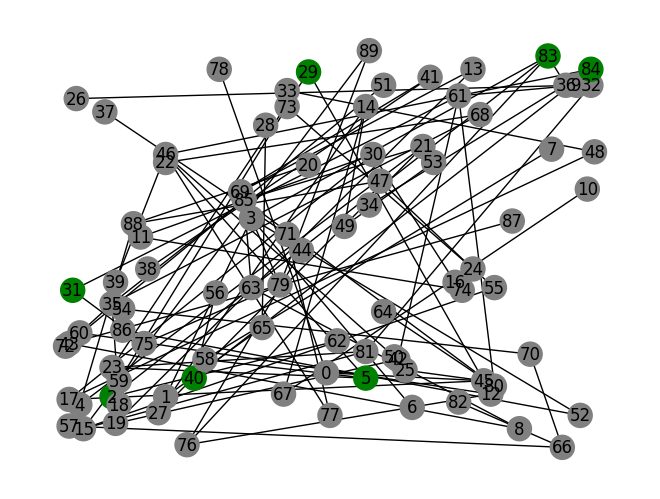

In [8]:
import networkx as nx
import utility_functions as uf

path_tree = "tree_net/bigtree.gml"
# READING THE TREE NETWORK FROM THE .gml FILE 
T = nx.read_gml(path_tree)

K = 3   # the number of flows
L = 150 # the battery capacity of the electric vehicle

flows = uf.get_random_flows(T, K)


def local_search(G, flows, L):
    charging_stations = set(G.nodes)  # initial solution
    uf.set_chrg_stations(G, list(charging_stations))
    cost = len(charging_stations)  # initial cost

    print(f"Initial solution: {charging_stations} and cost: {cost}")

    improved = True
    while improved:
        improved = False
        for node in list(charging_stations):
            charging_stations.remove(node)
            G.nodes[node]['chrg_station'] = False
            if uf.is_admissible(G, flows, L):
                cost -= 1
                improved = True
            else:
                charging_stations.add(node)
                G.nodes[node]['chrg_station'] = True

    return charging_stations, cost




charging_stations, cost = local_search(T, flows, L)
print(f"Charging stations: {charging_stations}")
print(f"Cost: {cost}")
uf.draw_tree(T)


### Altra ricerca locale
Implemento l'algoritmo di prima ma con la feature di cercare il minimo costo possibile e cioè se il costo risulta lo stesso valore per almeno depth volte consecutive

Initial solution: {'4', '73', '24', '19', '17', '21', '88', '6', '48', '7', '59', '87', '20', '64', '23', '8', '42', '18', '49', '43', '68', '76', '79', '77', '5', '67', '45', '75', '86', '54', '47', '53', '35', '16', '51', '3', '9', '37', '38', '80', '63', '56', '31', '44', '74', '29', '55', '0', '41', '70', '62', '12', '13', '26', '40', '60', '46', '28', '82', '58', '85', '52', '34', '72', '32', '15', '11', '2', '1', '33', '36', '25', '78', '71', '39', '69', '50', '89', '61', '57', '14', '84', '81', '65', '30', '22', '83', '66', '10', '27'} and cost: 90
Initial solution: {'4', '73', '24', '19', '17', '21', '88', '6', '48', '7', '59', '87', '20', '64', '23', '8', '42', '18', '49', '43', '68', '76', '79', '77', '5', '67', '45', '75', '86', '54', '47', '53', '35', '16', '51', '3', '9', '37', '38', '80', '63', '56', '31', '44', '74', '29', '55', '0', '41', '70', '62', '12', '13', '26', '40', '60', '46', '28', '82', '58', '85', '52', '34', '72', '32', '15', '11', '2', '1', '33', '36', '25

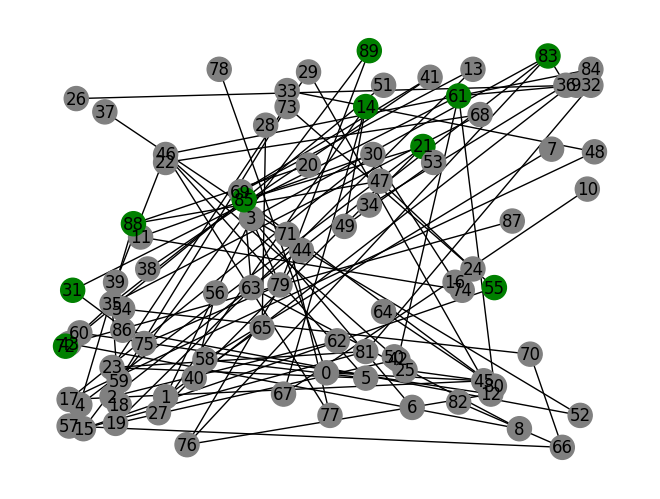

In [9]:
import networkx as nx
import utility_functions as uf

path_tree = "tree_net/bigtree.gml"
# READING THE TREE NETWORK FROM THE .gml FILE 
T = nx.read_gml(path_tree)

K = 3   # the number of flows
L = 150 # the battery capacity of the electric vehicle

flows = uf.get_random_flows(T, K)
depth = 1000 # number of consecutive iterations that cost must be the same value in the local search


def local_search(G, flows, L):
    charging_stations = set(G.nodes)  # initial solution
    uf.set_chrg_stations(G, list(charging_stations))
    cost = len(charging_stations)  # initial cost

    print(f"Initial solution: {charging_stations} and cost: {cost}")

    improved = True
    while improved:
        improved = False
        for node in list(charging_stations):
            charging_stations.remove(node)
            G.nodes[node]['chrg_station'] = False
            if uf.is_admissible(G, flows, L):
                cost -= 1
                improved = True
            else:
                charging_stations.add(node)
                G.nodes[node]['chrg_station'] = True

    return charging_stations, cost

def search(G, flows, L, depth):
    charging_stations, cost = local_search(G, flows, L)
    flag_cost = cost
    cont = 0

    while cont < depth:
        charging_stations, cost = local_search(G, flows, L)
        if cost == flag_cost:
            cont += 1
        else:
            cont = 0
        flag_cost = cost

    return charging_stations, cost

charging_stations, cost = search(T, flows, L, depth)

print(f"Charging stations: {charging_stations}")
print(f"Cost: {cost}")
uf.draw_tree(T)


# Un'altra greedy
Greedy scegliere il primo set per il primo flusso in maniera un po' randomica (dipende da noi se forward o backward o che ne so). Poi i successivi nodi basarsi su quello che si è già stato fatto. Vedere anche quale deve essere il primo flusso da considerare. Magari scegliere quello con il cammino maggiore visto che sicuramente avrà bisogno di più colonnine. In seguito in base a questo procedere con gli altri flussi tenendo conto di questo primo flusso e delle sue colonnine piazzate nel grafo.

In [ ]:
import networkx as nx
import utility_functions as uf

path_tree = "tree_net/bigtree.gml"
# READING THE TREE NETWORK FROM THE .gml FILE 
T = nx.read_gml(path_tree)

K = 3   # the number of flows
L = 150 # the battery capacity of the electric vehicle

flows = uf.get_random_flows(T, K)

def gen_first_set_nodes(G: nx.Graph, flow_path: list):
    first_charging_flow = set()
    




# Algoritmo costruttivo
Creare una matrice dei pesi dove si da un peso ad ogni nodo che dipende dal numero di path che lo percorre. Poi per ogni path dare un peso che dipdende dalla somma dei pesi dei nodi del path. Poi in base a questo utilizzare la matrice come info per decidere dove mettere le colonnine.

In [8]:
import networkx as nx
import utility_functions as uf
import numpy as np

# READING THE TREE NETWORK FROM THE .gml FILE 
path_tree = "tree_net/bigtree.gml"
T = nx.read_gml(path_tree)
K = 5   # the number of flows
L = 150 # the battery capacity of the electric vehicle
flows = uf.get_random_flows(T, K)





matrix_weights, flows_weights, nodes_weights = uf.get_weights_matrix(T, flows)

for k in range(K):
    print(f"Flow {flows[k]}: {flows_weights[k]}, {nodes_weights[k]}")




Flow ['1', '22']: 32, 6
Flow ['74', '73']: 14, 20
Flow ['72', '59']: 45, 25
Flow ['76', '34']: 20, 15
Flow ['4', '68']: 38, 13
